In [1]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.01MB/s]


In [3]:
# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")


Total number of '1' images in the training set: 6742


Shape of the flattened image: torch.Size([784])


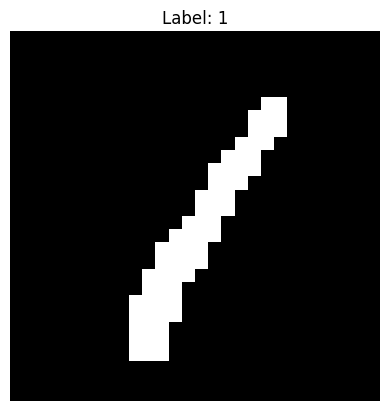

In [12]:
# Retrieve one sample from the filtered dataset
sample_img, sample_label = mnist_train_ones[0]

print("Shape of the flattened image:", sample_img.shape)  # Should be [784]

# Reshape back to 28x28 for visualization
img_reshaped = sample_img.view(28, 28)

plt.imshow(img_reshaped, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()


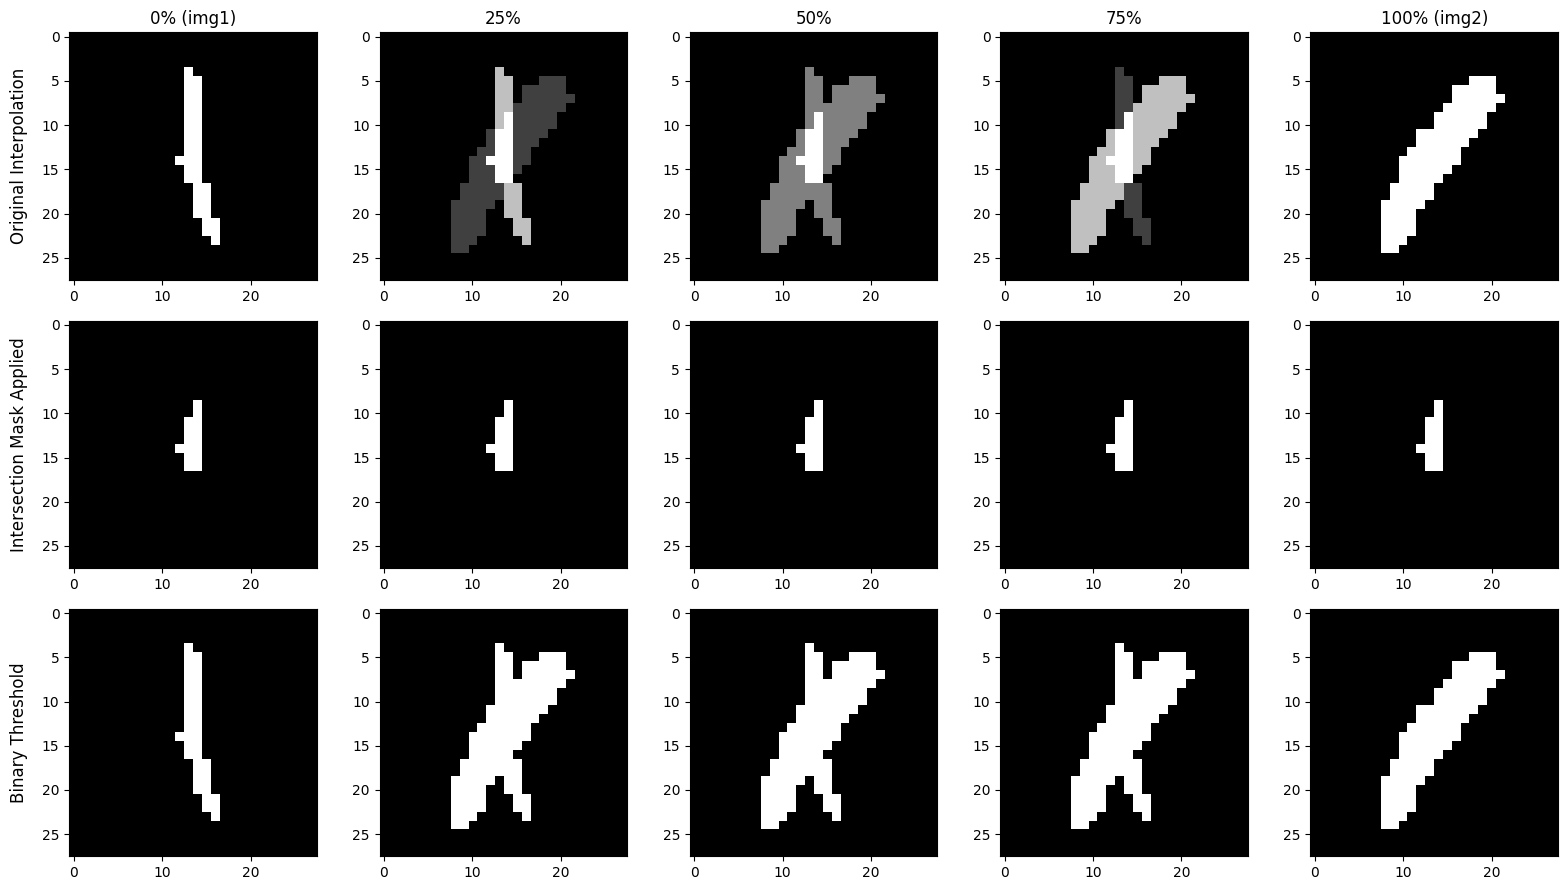

In [32]:
import random
import matplotlib.pyplot as plt

# Randomly sample two images from the filtered dataset of 1s
idx1 = random.randint(0, len(mnist_train_ones) - 1)
idx2 = random.randint(0, len(mnist_train_ones) - 1)
img1, label1 = mnist_train_ones[idx1]
img2, label2 = mnist_train_ones[idx2]

# Define interpolation factors including the originals (0% and 100%)
factors = [0.0, 0.25, 0.5, 0.75, 1.0]

# Precompute raw interpolations (they are still 784-dim vectors)
raw_interpolations = [(1 - t) * img1 + t * img2 for t in factors]

# Row 1: Original interpolated images (continuous values)
row1 = [ri.view(28, 28) for ri in raw_interpolations]

# Row 2: Only include pixels that are 1 in both original images.
# Compute a mask that is 1 only where both img1 and img2 have a 1.
mask = ((img1 == 1) & (img2 == 1)).float()
row2 = [(ri * mask).view(28, 28) for ri in raw_interpolations]

# Row 3: Threshold all nonzero pixels to 1.
row3 = [ (ri > 0).float().view(28, 28) for ri in raw_interpolations]

# Plot all rows in a 3 x 5 grid.
fig, axs = plt.subplots(3, 5, figsize=(16, 9))
titles = ["0% (img1)", "25%", "50%", "75%", "100% (img2)"]

# Set column titles for the top row
for j, title in enumerate(titles):
    axs[0, j].set_title(title)

# Define row labels
row_labels = ["Original Interpolation", "Intersection Mask Applied", "Binary Threshold"]

# Plot each row.
for i, row in enumerate([row1, row2, row3]):
    # Add a label to the first column of each row
    axs[i, 0].set_ylabel(row_labels[i], fontsize=12, labelpad=10)
    for j, img in enumerate(row):
        axs[i, j].imshow(img, cmap='gray')
        # axs[i, j].axis('off')

# Adjust subplot parameters to provide more space on the left
plt.subplots_adjust(left=0.15)

plt.tight_layout()
plt.show()


Minimum Euclidean distance: tensor(2.)


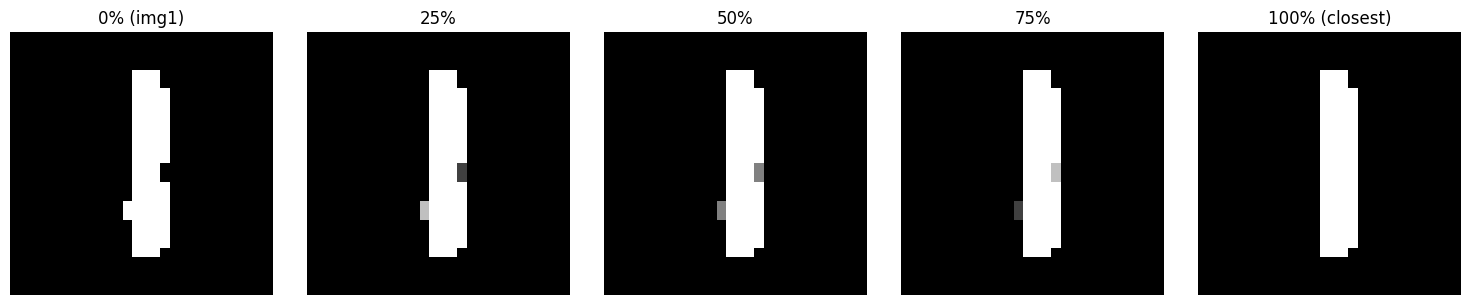

In [42]:
import random
import torch
import matplotlib.pyplot as plt

# Randomly choose a first image from the dataset of 1s
idx1 = random.randint(0, len(mnist_train_ones) - 1)
img1, label1 = mnist_train_ones[idx1]

# Find the closest image to img1 using Euclidean L2 distance
min_distance = float('inf')
closest_img = None
closest_idx = None

for i in range(len(mnist_train_ones)):
    if i == idx1:  # Skip the same image
        continue
    candidate, _ = mnist_train_ones[i]
    # Compute the L2 (Euclidean) distance between img1 and candidate
    distance = torch.dist(img1, candidate, p=2)
    if distance < min_distance:
        min_distance = distance
        closest_img = candidate
        closest_idx = i

print("Minimum Euclidean distance:", min_distance)

# Define interpolation factors (0% and 100% correspond to img1 and closest_img)
factors = [0.0, 0.25, 0.5, 0.75, 1.0]
interpolated_images = []
for t in factors:
    interp_img = (1 - t) * img1 + t * closest_img  # Linear interpolation
    interpolated_images.append(interp_img.view(28, 28))  # Reshape to 28x28 for plotting

# Plot the original images and interpolated results
fig, axs = plt.subplots(1, len(interpolated_images), figsize=(15, 3))
titles = ["0% (img1)", "25%", "50%", "75%", "100% (closest)"]

for ax, img, title in zip(axs, interpolated_images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
